## Experimentation with GravNet

In [13]:
import wandb
import torch
from functools import partial
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import RichProgressBar
# from wandb_osh.lightning_hooks import TriggerWandbSyncLightningCallback

from model import Model

from gnn_tracking.metrics.losses import PotentialLoss, BackgroundLoss
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.training.callbacks import PrintValidationMetrics
from gnn_tracking.training.tc import TCModule
from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScanner

In [2]:
name = "TEST_NAME"

logger = WandbLogger(
    project="jian-point_cloud_net",
    group="test",
    offline=True,
    version=name,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id TEST_NAME.


In [3]:
wandb.define_metric(
    "max_mcc_pt0.9",
    step_metric="max_mcc_pt0.9",
    summary="max",
)

In [4]:
tb_logger = TensorBoardLogger(".", version=name)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device:", device)

Current device: cpu


In [6]:
dm = TrackingDataModule(
    train=dict(
        dirs=["/Users/fuchur/tmp/truth_cut_graphs_for_gsoc/part_1_0/"],
        stop=5,
    ),
    val=dict(
        dirs=["/Users/fuchur/tmp/truth_cut_graphs_for_gsoc/part_1_0/"],
        start=5,
        stop=10,
    ),
)

In [7]:
model = Model(embed_dim = 64, space_dim = 4, num_layers = 4)

In [8]:
# TC for track condensation
lmodel = TCModule(
    model=model,
    potential_loss=PotentialLoss(
        radius_threshold=1.0,
    ),
    background_loss=BackgroundLoss(),
    lw_repulsive=2.0,
    lw_background=0.1,
    optimizer=partial(torch.optim.Adam, lr=1e-4),
    cluster_scanner=DBSCANHyperParamScanner(n_trials=5, n_jobs=1),
)

In [11]:
trainer = Trainer(
    max_epochs=1,
    accelerator=device,
    log_every_n_steps=1,
    callbacks=[
        PrintValidationMetrics()
    ],
    logger=logger
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model=lmodel, datamodule=dm)

FileNotFoundError: Directory /Users/fuchur/tmp/truth_cut_graphs_for_gsoc/part_1_0/ does not exist.

### 7. Visualise Model

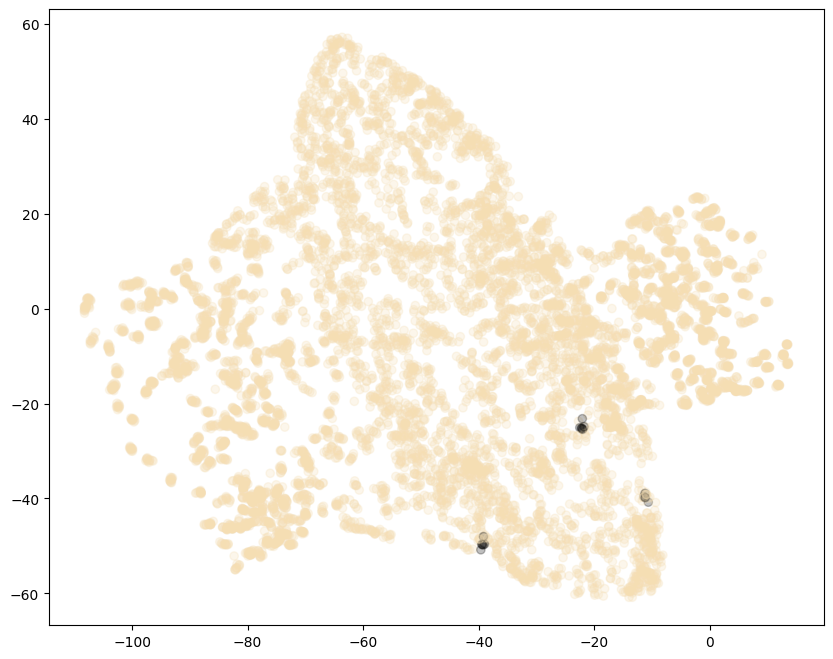

In [61]:
# View three random particle's hits in the generated latent space (from test set)

y, _ = gravnet(raw_data[850].x)
POS = y.detach()
ID = raw_data[850].particle_id

id_np = ID.to('cpu').numpy()
pos_np = POS.to('cpu').numpy()

unique_ids = np.unique(id_np)
highlight_id = np.random.choice(unique_ids)
highlight_id_2 = np.random.choice(unique_ids)
highlight_id_3 = np.random.choice(unique_ids)

colors = ['black' if (id == highlight_id or id == highlight_id_2 or id == highlight_id_3) else 'wheat' for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors, alpha=0.25)
plt.show()